## One- and Two-Dimensional Scans of Potential Energy

### Introduction

In this notebook, we will perform 1D and 2D scans of molecular potential energies using `tqchem`. The aim is to calculate and visualize the potential energy of a molecule (octane) as a function of torsion angle(s). We will cover the following steps:

1. Set up the molecule and the calculation parameters.
2. Perform the energy calculations for different torsion angles.
3. Save the trajectory of the molecule.
4. Plot and visualize the results.

### Step 1: Setting Up Paths and Parameters
In this step, we import the necessary dependencies, define the input and output paths, create the molecule object and display it as a graph and 3D model.

**Code Explanation**

We specify the path to the XYZ file of the molecule and create an output directory for saving results, 
From the XYZ file we create a `MolecularSystem` and call `draw` to display its graph representation.
By calling `plot_3D_molecule` we display the 3D structure of the molecule using py3Dmol.

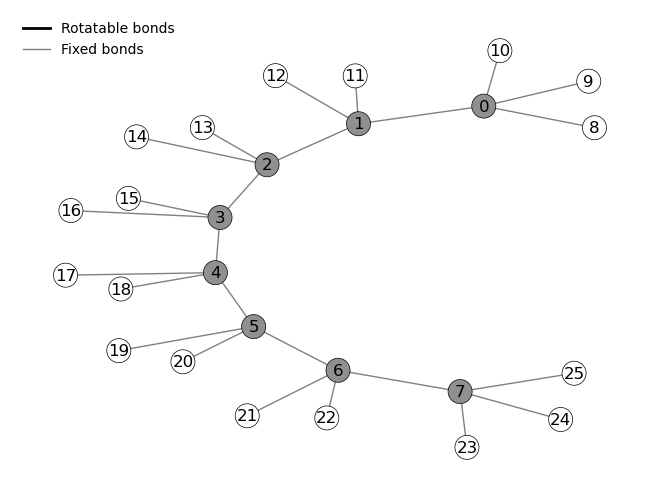

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [1]:
import numpy as np
from pathlib import Path
from plotly import graph_objects as go

from tqchem.ttconf.electronic_structure_interfaces import TBliteInterface
from tqchem.molgraph import molecularSystem
from tqchem.internal_coordinates import MolecularGrid
from tqchem.chem import xyz_contents
from tqchem.viewer import plot_3D_molecule, display_trajectory


xyz = Path("../tests/octane.xyz")
output_dir = Path(".outputs_screen_energy")
output_dir.mkdir(exist_ok=True)

# read octane.xyz into MoleculrSystem class and draw the graph/molecule
octane = molecularSystem(xyz)
octane.draw()
view = plot_3D_molecule(octane.ase)
view.show()

### Step 2: Internal coordinates and bond to screen

In this step, set up the internal coordinates for octane (Bonds, Angles and Torsions) and we define the bond to be rotated, and the grid of torsion angles.

**Code Explanation**

We choose a number of grid points, i.e. how many points we want to sample when rotating around the bond.
Because `molecularSystem` sets sensible default grids for each bond (used in the conformer optimization), we need to reconstruct the molecular system while overwriting these default grids with the grid we want.
Then we set up the `MolecularGrid` for octane which constructs the
internal coordinates for the system. The `shift_by_reference` keyword, let's change dihedral values based on the initial structure instead of setting all dihedrals to 0.0 initially.
We determine the bond we want to rotate around as index of the list of `variable_atom_indices`.


In [2]:
n_gridpoints = 120
dihedral_angles = np.linspace(0, 360, n_gridpoints, endpoint=False)
octane = molecularSystem(xyz)

molecule_grid = MolecularGrid(
    octane, shift_by_reference=True, overwrite_grids=dihedral_angles
)
print(molecule_grid.variable_atom_indices())
bond_grid_shape = molecule_grid.shape()

bond_index = 2

['Bond(1, 2)', 'Bond(2, 3)', 'Bond(3, 4)', 'Bond(4, 5)', 'Bond(5, 6)']


### Step 3: Screen single coordinate

We first set up an energy calculator (using the GFN2-xTB method) and an output file to store all the geometries of octane while scanning the coordinate.
We then loop through the values of the coordinate, calculate the energy and save the coordinates in the trajectory file.

**Code Explanation**

The `superindex` is a list of indices telling each variable (rotatable bond) of the molecular grid, which value of the grid it should assume.

In [3]:
superindex = [0] * molecule_grid.n_variables()

energy_calculator = TBliteInterface(
    method="GFN2-xTB", ref_mol=octane.ase, local_optimization=False
)
energies = []
xyzs = []

output_name = "octane34"

for i in bond_grid_shape[bond_index]:
    superindex[bond_index] = i
    molecule = molecule_grid(superindex)
    energies.append(energy_calculator(molecule.ase))
    xyzs.append(xyz_contents(molecule.ase))

trajectory_file = output_dir / f"{output_name}.xyz"
_ = trajectory_file.write_text("".join(xyzs))

### Step 4: Plot results

We convert the gridpoints into degree of the dihedral angle and plot the energy as a function of the dihedral angle.

In [4]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dihedral_angles, y=energies, mode="lines+markers"))
fig.update_layout(xaxis_title="Dihedral of Bond(4,3) (°)", yaxis_title="Energy (eV)")
fig.show()

output_html = output_dir / f"{output_name}.html"
fig.write_html(output_html)

### Step 5: Visualize the conformers during the screening

In [5]:
view = display_trajectory(xyzs, repetitions=1, time=30)
view.show()
# view.apng(100) # display as animated png (apng)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Step 6: Screening two coordinates

We now want to screen two dihedral angles and select the bond connecting the carbon atoms 2 and 3
and the bond connecting carbon atom 3 and 4.
To reduce the computational time we select only 25 grid points per coordinate,
for which we set up a new `molecularSystem` and `MolecularGrid` object.

In [6]:
n_gridpoints = 25
dihedral_angles = np.linspace(0, 360, n_gridpoints, endpoint=False)
octane = molecularSystem(xyz)

molecule_grid = MolecularGrid(
    octane, shift_by_reference=True, overwrite_grids=dihedral_angles
)
print(molecule_grid.variable_atom_indices())
grid = molecule_grid.shape()
print(grid)

bond_index1 = 1
bond_index2 = 2

['Bond(1, 2)', 'Bond(2, 3)', 'Bond(3, 4)', 'Bond(4, 5)', 'Bond(5, 6)']
[range(0, 25), range(0, 25), range(0, 25), range(0, 25), range(0, 25)]


### Step 7: Screen two coordinates

We now repeat Step 3, but instead of iterating over the grid for one coordinate,
we iterate over the product of the two coordinates.

In [7]:
from itertools import product

superindex = [0] * molecule_grid.n_variables()

energy_calculator = TBliteInterface(
    method="GFN2-xTB", ref_mol=octane.ase, local_optimization=False
)
energies = np.zeros((n_gridpoints, n_gridpoints))
xyzs = []

output_name = "octane_23_34"
trajectory_file = output_dir / f"{output_name}.xyz"

for i, j in product(grid[bond_index1], grid[bond_index2]):
    superindex[bond_index1] = i
    superindex[bond_index2] = j
    molecule = molecule_grid(superindex)
    energies[i, j] = energy_calculator(molecule.ase)
    xyzs.append(xyz_contents(molecule.ase))

_ = trajectory_file.write_text("".join(xyzs))

In [8]:
view = display_trajectory(xyzs, repetitions=1, time=100)
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Step 8: Plot energy as a function of both dihedral angles

In [9]:
# Create a 2D surface plot of the energy landscape
fig = go.Figure(
    data=[
        go.Surface(
            # z=-1.0 / np.sqrt(np.abs(energies)),
            z=energies,
            x=dihedral_angles,
            y=dihedral_angles,
        )
    ]
)

fig.update_scenes(
    xaxis_title="Dihedral of Bond(3,2) (°)",
    yaxis_title="Dihedral of Bond(4,3) (°)",
    zaxis_title="Energy (eV)",
)
fig.update_layout(
    title="Surface plot of energy",
    autosize=False,
    width=700,
    height=700,
    margin=dict(l=50, r=50, b=50, t=60),
)
fig.show()